# POA Transposition Model Validation
The purpose of this notebook is to validate the use of new or current POA transposition models through multiple steps of analysis. 

<li><b>1. Import data from DuraMAT</b></li>
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx
<li><b>2. Define relevant system & meteo data</b></li>
<li><b>3. Run model to be validated or import model results</b></li>
<li><b>4. Compare model to measured results and other baseline models</b></li>

In [1]:
#import necessary packages and set default formatting for plots
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import pvlib
import pvanalytics
import sklearn.metrics
import scipy
from matplotlib.lines import Line2D
from tabulate import tabulate

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12

## 1. Import data

In [2]:
#read in data from duramat data hub directly
df = pd.read_excel('pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx', sheet_name='S2')
#df = pd.read_excel(https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx,
#                   sheet_name='S2'

#Reassigning the index so the timesteps are at the middle of the hour
df.index = pd.date_range(start='2021-01-01 00:30:00', end='2021-12-31 23:30:00', freq='H')
df.index = df.index.tz_localize('MST')

#apply the filters that are included in the data & replacing any 0 with nan so they dont affect error metrics
#dropping nans helps keep size down so operations run more quickly and smoothly
df = df.where((df['bsrn_pass'] == 1) & (df['SNL No Snow'] == 1)).dropna()
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)

df.head()

,Scenario,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),Measured front POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),bsrn_pass,SNL No Snow
2021-01-01 08:30:00-07:00,S2,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,442.132104,6.645174,1292.814741,1.0,1.0
2021-01-01 09:30:00-07:00,S2,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,701.031595,17.712519,2276.603041,1.0,1.0
2021-01-01 10:30:00-07:00,S2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.089500,2.962067,879.164182,25.669461,2782.780150,1.0,1.0
2021-01-01 11:30:00-07:00,S2,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,977.788429,35.226433,2989.486270,1.0,1.0
2021-01-01 12:30:00-07:00,S2,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,922.354253,38.056121,2796.495393,1.0,1.0


## 2. Define system and meteo data

In [3]:
#Defining constants and values that are consistent across all calculations
#we are using S2 from the data, which is the Candian Solar Monocrystalline 275W module
module = {'Tilt': 35,'Latitude': 35.05,'Longitude': -106.54,'Altitude': 1600,'Surface Azimuth': 180,'String Length':12, 'iam0':1,'iam10': 0.9989, 'iam20': 1.0014, 'iam30': 1.0002, 'iam40':0.9984, 
          'iam45': 0.9941, 'iam50': 0.9911, 'iam55': 0.9815, 'iam60':0.9631, 'iam65':0.9352, 'iam70':0.8922, 'iam75':0.8134, 'iam80':0.6778, 'iam85': 0.4351,
         'U0': 28.825, 'U1': 4.452, 'NOCT': 45, 'Unit Mass': 11.119, 'Area':1.621, 'Pmp' : 275, 'Gamma Pmp': -0.0041, 'Alpha Isc':0.0033,
          'Beta Voc': -0.1178, 'Cell Type':'monoSi', 'Cells in Series':60}
module = pd.Series(module)

#Running solar position calculations
spdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['Latitude'], 
        longitude=module['Longitude'],temperature=df['Ambient Temp (°C) '], altitude=module['Altitude'])
spdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
pres = pvlib.atmosphere.alt2pres(module['Altitude'])

#Save these values into the df with inputs & results for use in later analysis
df['Azimuth'] = spdf['azimuth']
df['Zenith'] = spdf['apparent_zenith']
df['Sol Elev'] = spdf['elevation']
df['AOI'] = pvlib.irradiance.aoi(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'],solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'])
df['Airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])
df['Clearness Index'] = pvlib.irradiance.clearness_index(ghi=df['GHI (W/m2)'], solar_zenith=spdf['apparent_zenith'], extra_radiation = spdf['dni_extra'])
spdf.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,dni_extra
2021-01-01 08:30:00-07:00,77.884310,77.950122,12.115690,12.049878,129.546848,-3.734135,1413.981805
2021-01-01 09:30:00-07:00,69.241432,69.279260,20.758568,20.720740,140.756151,-3.753597,1413.981805
2021-01-01 10:30:00-07:00,62.615700,62.643406,27.384300,27.356594,154.026282,-3.773049,1413.981805
2021-01-01 11:30:00-07:00,58.731118,58.754688,31.268882,31.245312,169.230769,-3.792492,1413.981805
2021-01-01 12:30:00-07:00,58.153100,58.176057,31.846900,31.823943,185.427677,-3.811925,1413.981805


## 3. Run the model or import the results to be validated

In [4]:
#Either run a model in this notebook or import the results into the column name below


#run model here
df['Modeled POA'] = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
                    solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'],dni=df['DNI (W/m2)'],
                    ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=spdf['dni_extra'], model ='perez', model_perez='albuquerque1988')['poa_global']

# or import model results here. Make sure timestamps line up and are middle-of-hour
# df['Modeled POA'] = pd.read_excel('results.xlsx')

#specify a model name for use in analysis and plotting
model_name = 'perez'



### Visualize the results of the model over a sample day 
This preliminary check helps make sure the results are feasible and there aren't any obvious errors like time shifts or magnitude differences

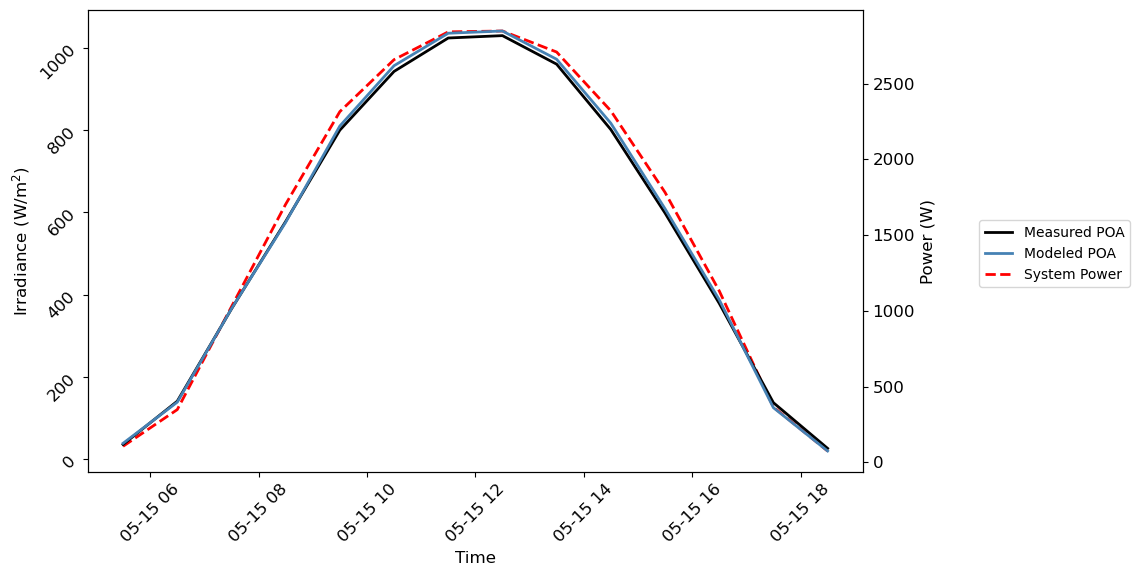

In [5]:
#diurnal plot
day = 15
month = 5

fig, ax = plt.subplots()
ax.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured front POA irradiance (W/m2)'], linewidth=2, color='black', zorder=5.5)
ax.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Modeled POA'], linewidth=2, color='steelblue', zorder=5.5)

ax.tick_params(labelrotation = 45)
ax.set_ylabel('Irradiance (W/m$^2$)')
ax.set_xlabel('Time')
ax2 = ax.twinx()
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured DC power (W)'], linewidth=2,linestyle='dashed',color='red',zorder=2.5)
ax2.set_ylabel('Power (W)')
plt.grid(False)
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

line_1 = Line2D([0], [0], color='black', linewidth=2, linestyle='-',label='Measured POA')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Modeled POA')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='System Power')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.15, 0.4],handles=lines)

## 4. Compare modeled values to measured values + other baseline models

### 3 steps of analysis:
<li><b>1. Overall NMBE, MBE, RMSE, NRMSE, and other errors of the model</b></li>
<li><b>2. Residual analysis</b></li>
<li><b>3. Comparison to baseline model</b></li>

### Analysis I: Overall errors of the model
#### • Normalized Mean Bias Error (NMBE) - shows the estimation bias of the model
###                 $100 * \frac{V_{modeled} - V_{measured}}{V_{measured}}$


#### • Root Mean Squared Error (RMSE) - measures average difference between modeled and measured values
### $ \sqrt{\frac{1}{N} \sum_{i=1}^{N}(V_{modeled}-V_{measured})^2} $

In [6]:
df['NBE'] = 100 * (df['Modeled POA'] - df['Measured front POA irradiance (W/m2)'])/(df['Measured front POA irradiance (W/m2)'])
nmbe = df['NBE'].mean()
df['BE'] = (df['Modeled POA'] - df['Measured front POA irradiance (W/m2)'])
mbe = df['BE'].mean()
rmse = sklearn.metrics.mean_squared_error(df.dropna()['Modeled POA'],df.dropna()['Measured front POA irradiance (W/m2)'], squared=False)
nrmse = 100 * rmse/(df['Measured front POA irradiance (W/m2)'].mean())
#print these in a neat table 
d = [['NMBE', str(round(nmbe,3))+' %'], ['MBE', str(round(mbe,3))+' W/m2'], ['NRMSE', str(round(nrmse,3))+' %'], ['RMSE',str(round(rmse,3))+' W/m2']]
print (tabulate(d, headers=["Metric", "Value"]))

Metric    Value
--------  -----------
NMBE      -0.769 %
MBE       3.674 W/m2
NRMSE     2.197 %
RMSE      12.675 W/m2


Text(0.5, 1.0, 'Measured vs Modeled Values')

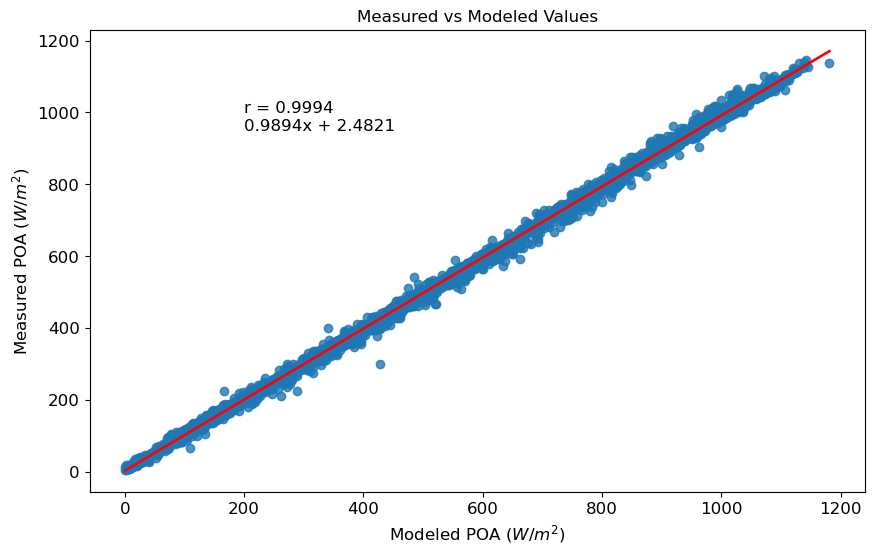

In [7]:
slope, intercept, r, p, std = scipy.stats.linregress(x = df.dropna()['Modeled POA'], y = df.dropna()['Measured front POA irradiance (W/m2)'])
sns.regplot(x = df['Modeled POA'], y = df['Measured front POA irradiance (W/m2)'], line_kws={'color':'red'})

plt.ylabel('Measured POA ($W/m^2$)')
plt.xlabel('Modeled POA ($W/m^2$)')
plt.text(200, 1000, s = ("r = "+str(round(r,4))))
plt.text(200, 950, s = (str(round(slope,4))+'x + '+str(round(intercept,4))))
plt.title('Measured vs Modeled Values')

#The plot should be mostly linear. r and slope values close to one indicate good correlation and accurate model performance

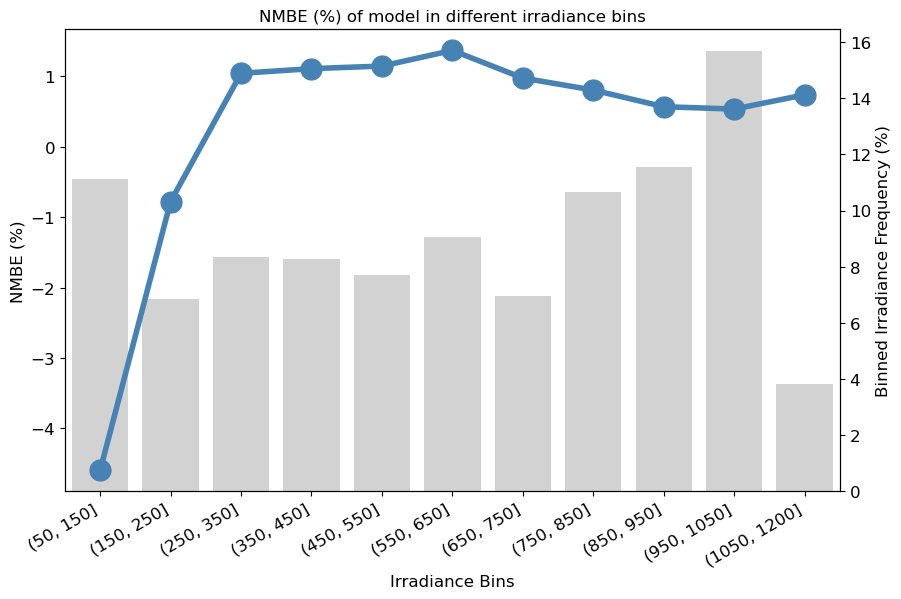

In [8]:
#plotting NMBE for each irradiance bin to see performance at different irradiance levels
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'Irradiance Bins' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df.groupby('Irradiance Bins').mean().sort_values('Irradiance Bins')['NBE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=4, markersize=15)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('NMBE (%)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plt.title('NMBE (%) of model in different irradiance bins')
plt.show()


### Energy Yield Estimates
We can run two simulations, one using the POA model and another using true POA data to see how much influence the errors of the model have on the predicted overall energy yield

In [9]:
#using measured POA to estimate energy
df['DC Power - Meas POA'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Measured front POA irradiance (W/m2)'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Measured front POA irradiance (W/m2)'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#using modeled POA to estimate energy
df['DC Power - Model POA'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Modeled POA'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Modeled POA'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#find overall % diff for annual energy
print('With measured POA, predicted annual energy is', round(df['DC Power - Meas POA'].sum()/1000,3),
      'kWh and with modeled POA, predicted annual energy is', round(df['DC Power - Model POA'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using measured vs modeled POA is ', round(((df['DC Power - Model POA'].sum()-df['DC Power - Meas POA'].sum())/df['DC Power - Meas POA'].sum())*100,3),'%')

With measured POA, predicted annual energy is 6739.188 kWh and with modeled POA, predicted annual energy is 6780.385 kWh
The % difference in energy estimate when using measured vs modeled POA is  0.611 %


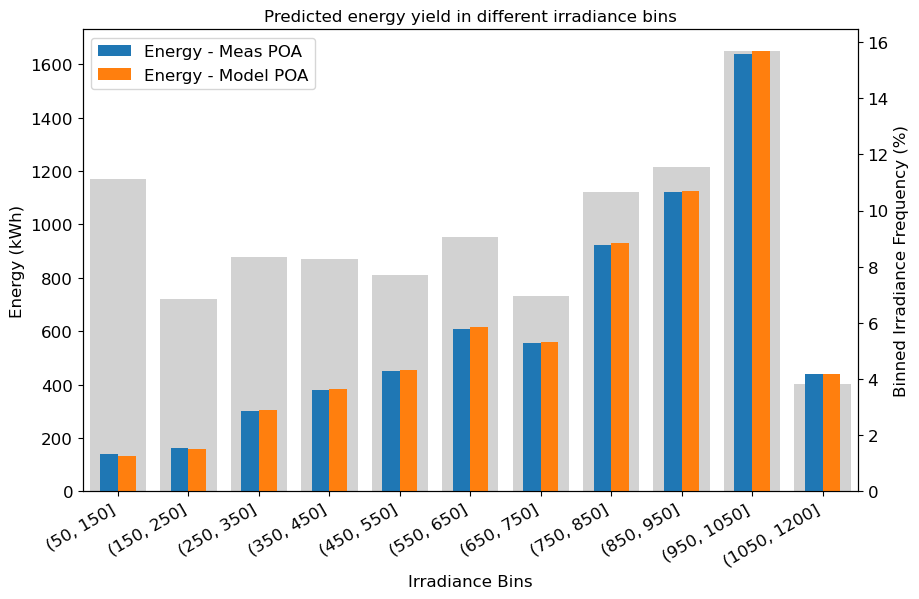

In [10]:
#we can plot the energy produced in each bin of irradiance and see where the largest differences are when using modeled/measured POA

bins['Energy - Model POA'] = df.groupby('Irradiance Bins').sum()['DC Power - Model POA']/1000
bins['Energy - Meas POA'] = df.groupby('Irradiance Bins').sum()['DC Power - Meas POA']/1000
bins = bins.sort_values('Irradiance Bins')

ax = bins.plot(x="Irradiance Bins", y=["Energy - Meas POA", "Energy - Model POA"], kind="bar", rot=0)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Energy (kWh)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)


plt.title('Predicted energy yield in different irradiance bins')
plt.show()


### Analysis II: Residual Analysis
#### • Residual Analysis - quantifies the degree that variables may affect model errors
### $V_{modeled} - V_{measured}$

### Residual Distribution
Residuals should be normally distributed, otherwise this indicates a consistent bias of over or under predicting \
To get a closer look at a majority of the residuals, the outer 1% are removed using z-score. The distribution should be centered about the mean, shown by the red line

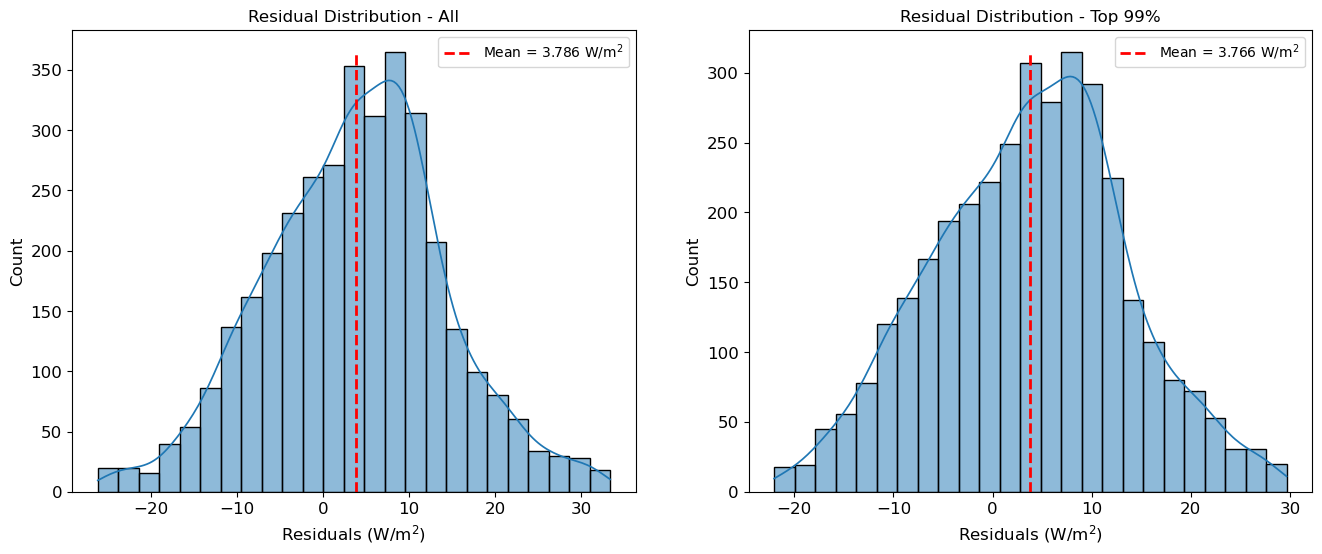

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

df['Residuals'] = (df['Modeled POA'] - df['Measured front POA irradiance (W/m2)'])
hsp = sns.histplot(df['Residuals'], kde=True, bins=25, ax=ax1)
h = []
for rectangle in hsp.patches:
    h.append(rectangle.get_height())
ax1.vlines(x=df['Residuals'].mean(), ymin=0, ymax=max(h), linewidth=2, color='red',linestyles='--')
ax1.set_title('Residual Distribution - All')
ax1.set_xlabel('Residuals (W/m$^2$)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['Residuals'].mean(),3))+' W/m$^2$'))]
ax1.legend(prop=dict(size='small'),handles=line_4)

#Use z-score to eliminate the outer 1% of residuals
df['zscore'] = scipy.stats.zscore(df['Residuals'].dropna())
df['resid_trim'] = df['Residuals'][(df['zscore'] < 2.5) & (df['zscore'] > -2.5)]
hsp = sns.histplot(df['resid_trim'], kde=True, bins=25, ax=ax2)
h = []
for rectangle in hsp.patches:
    h.append(rectangle.get_height())
ax2.vlines(x=df['resid_trim'].mean(), ymin=0, ymax=max(h), linewidth=2, color='red',linestyles='--')
ax2.set_title('Residual Distribution - Top 99%')
ax2.set_xlabel('Residuals (W/m$^2$)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['resid_trim'].mean(),3))+' W/m$^2$'))]
ax2.legend(prop=dict(size='small'),handles=line_4)

Text(764.6928104575164, 0.5, 'Model Residuals ($W/m^2$)')

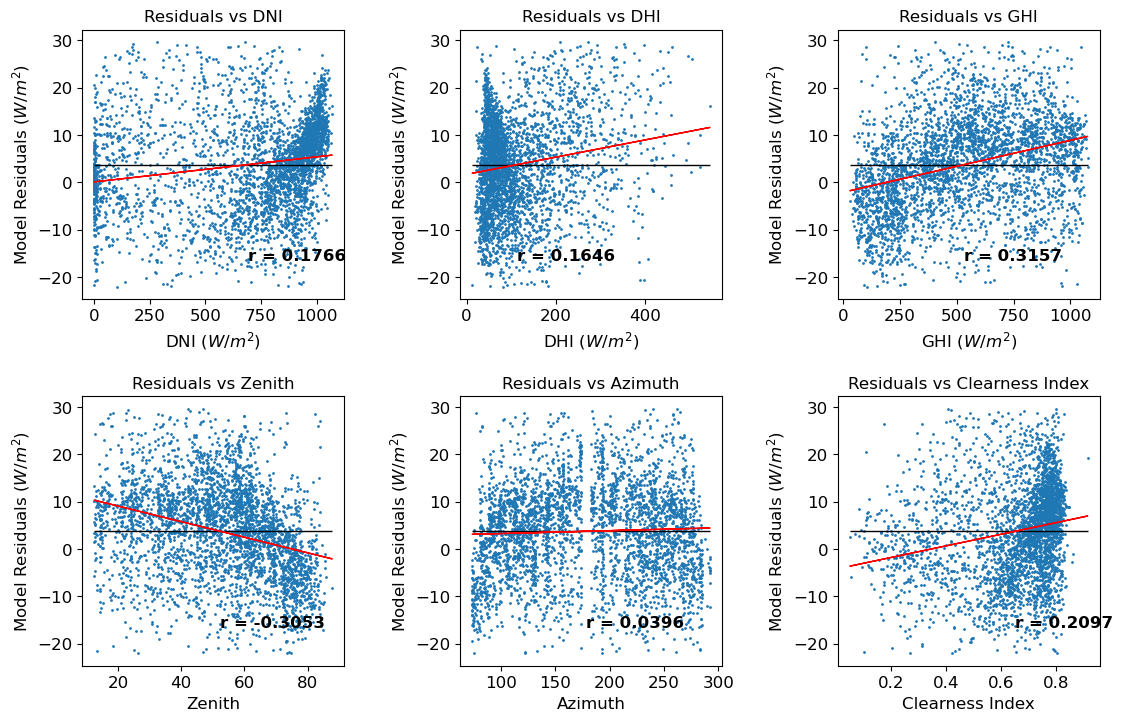

In [26]:
#plot residuals against common inputs into POA models

fig, axs = plt.subplots(2, 3,figsize=(12,8))
fig.tight_layout(pad=4.0)
# y = df['Residuals']
# y_avg = df['Residuals'].mean()
# y_med = df['Residuals'].median()
df = df.dropna()
y = df['resid_trim']
y_avg =  df['resid_trim'].mean()
y_med =  df['resid_trim'].median()
x = df['DNI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 0].scatter(x, y, s=1)
axs[0, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[0, 0].plot(x, p(x), linewidth=1, color='red')
axs[0, 0].set_title('Residuals vs DNI')
axs[0, 0].set_xlabel('DNI ($W/m^2$)')
axs[0, 0].set_ylabel('Model Residuals ($W/m^2$)')
x = df['DHI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 1].scatter(x, y, s=1)
axs[0, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[0, 1].plot(x, p(x), linewidth=1, color='red')
axs[0, 1].set_title('Residuals vs DHI')
axs[0, 1].set_xlabel('DHI ($W/m^2$)')
axs[0, 1].set_ylabel('Model Residuals ($W/m^2$)')
x = df['GHI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 2].scatter(x, y, s=1)
axs[0, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 2].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[0, 2].plot(x, p(x), linewidth=1, color='red')
axs[0, 2].set_title('Residuals vs GHI')
axs[0, 2].set_xlabel('GHI ($W/m^2$)')
axs[0, 2].set_ylabel('Model Residuals ($W/m^2$)')
x = df['Zenith']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 0].scatter(x, y, s=1)
axs[1, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[1, 0].plot(x, p(x), linewidth=1, color='red')
axs[1, 0].set_title('Residuals vs Zenith')
axs[1, 0].set_xlabel('Zenith')
axs[1, 0].set_ylabel('Model Residuals ($W/m^2$)')
x = df['Azimuth']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 1].scatter(x, y, s=1)
axs[1, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[1, 1].plot(x, p(x), linewidth=1, color='red')
axs[1, 1].set_title('Residuals vs Azimuth')
axs[1, 1].set_xlabel('Azimuth')
axs[1, 1].set_ylabel('Model Residuals ($W/m^2$)')
x = df['Clearness Index']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 2].scatter(x, y, s=1)
axs[1, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 2].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[1, 2].plot(x, p(x), linewidth=1, color='red')
axs[1, 2].set_title('Residuals vs Clearness Index')
axs[1, 2].set_xlabel('Clearness Index')
axs[1, 2].set_ylabel('Model Residuals ($W/m^2$)')



## Plotting residuals vs AOI with division of some metric (Hour, Clearness Index, etc)
#### Describes time of day dependence

Text(0.5, 1.0, 'Residuals of Model at High and Low Clearness Index levels')

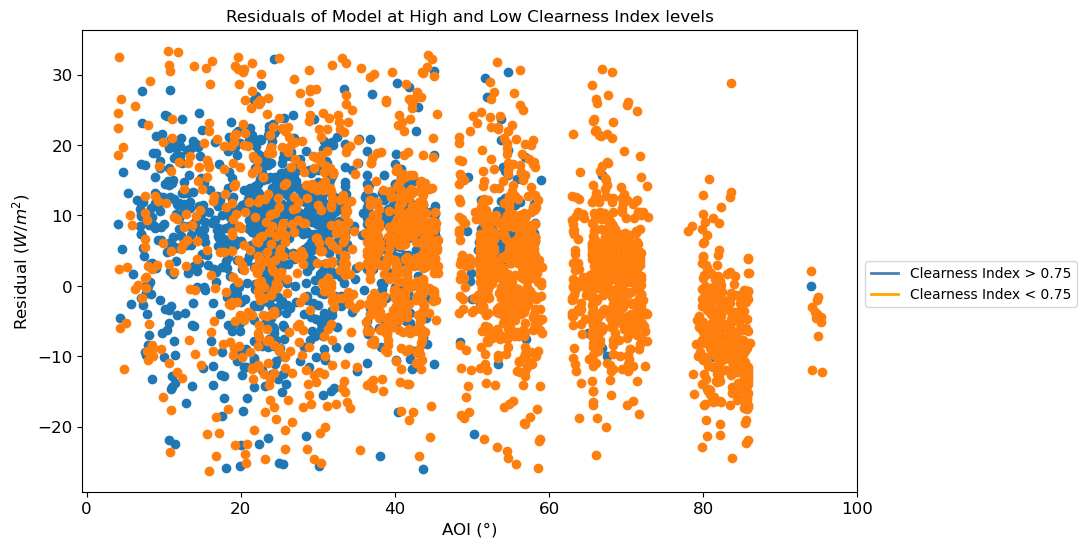

In [13]:
#select a metric, must be a column in the df
metric = 'Clearness Index'
#set the value to split the data into upper and lower
bound = 0.75

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

plt.scatter(x=df_h['AOI'], y=df_h['resid_trim'])
plt.scatter(x=df_l['AOI'], y=df_l['resid_trim'])

plt.ylabel('Residual ($W/m^2$)')
plt.xlabel('AOI (°)')

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=(metric+' > '+str(bound)))
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label=(metric+' < '+str(bound)))
lines = [line_1,line_3]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('Residuals of Model at High and Low '+metric+' levels')

### Residuals by month
Grouping the residuals by month is one way to check if the model has any extreme behavior in specific seasons of the year \
This is done below with a boxplot which shows the spread of the data within the months and a jointplot which can show this and the distribution of the data across the months as well

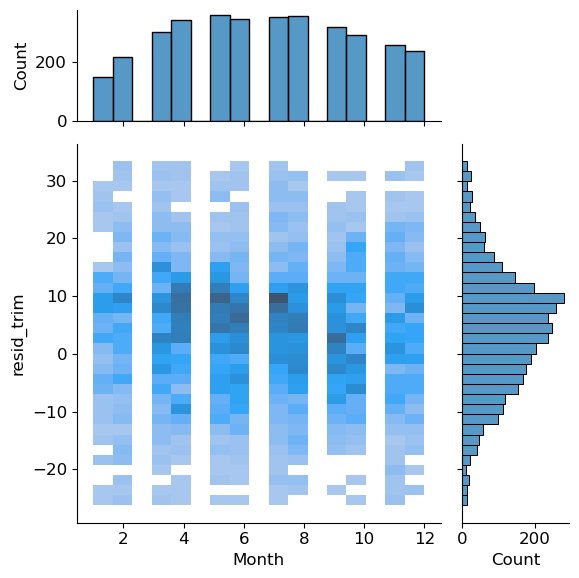

In [14]:
sns.jointplot(data=df, x='Month', y='resid_trim', kind='hist',marginal_ticks=True, dropna=True, ratio=3)

Text(0.5, 1.0, 'Model Residuals by Month')

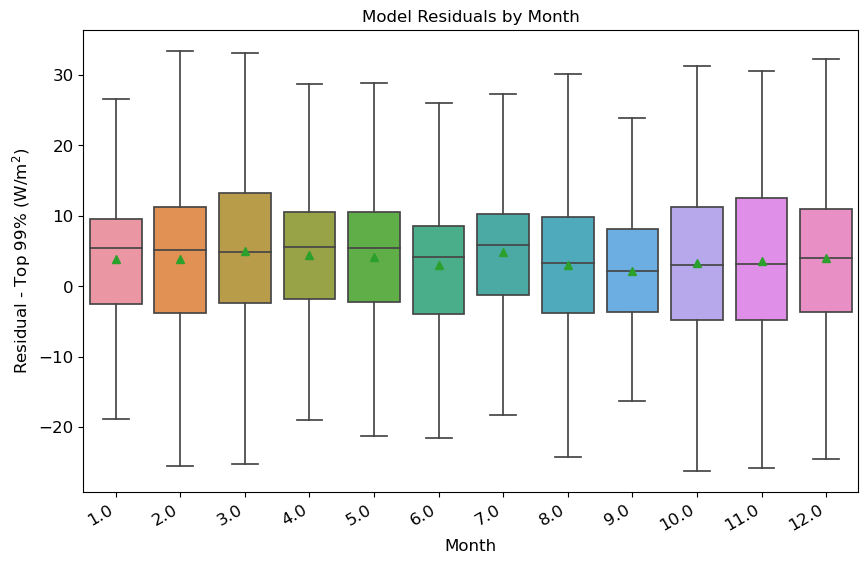

In [15]:
sns.boxplot(data=df, x='Month', y='resid_trim', showfliers=False, showmeans=True)
plt.xticks(rotation=30, ha='right')
plt.ylabel('Residual - Top 99% (W/m$^2$)')
plt.title('Model Residuals by Month')

### Analemma Plots
These are another way to check seasonality of a model and can also show how the model performs at specific times of day

Text(0.5, 0, 'Solar Azimuth')

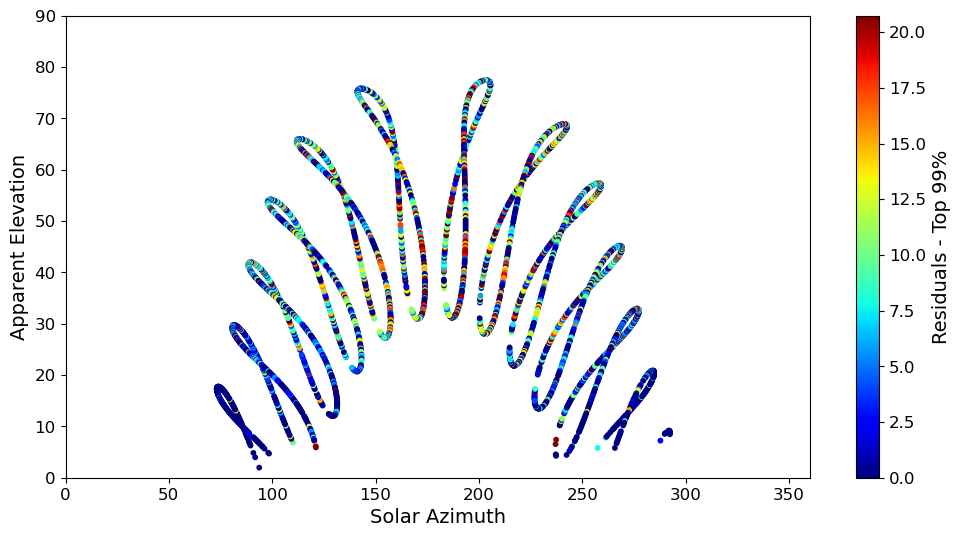

In [16]:
#analemma plots show the residuals at different times of the day/year
plt.figure(figsize=(12,6))
plt.scatter(x=df['Azimuth'], y=df['Sol Elev'], c=df['resid_trim'], cmap='jet', s=10)
clb = plt.colorbar()
clb.ax.set_ylabel('Residuals - Top 99%',fontsize =14)
plt.clim(0,(df['resid_trim'].describe()['75%'] + df['resid_trim'].describe()['std']))
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation', fontsize=14 )
plt.xlabel('Solar Azimuth',fontsize =14)

### Empirical Cumulative Distribution Plot (ECDF)
This plot shows the cumulative distribution of the residuals with the median as the dashed line and the mean as the solid line


Text(0.5, 1.0, 'ECDF of Model Residuals - Top 99%')

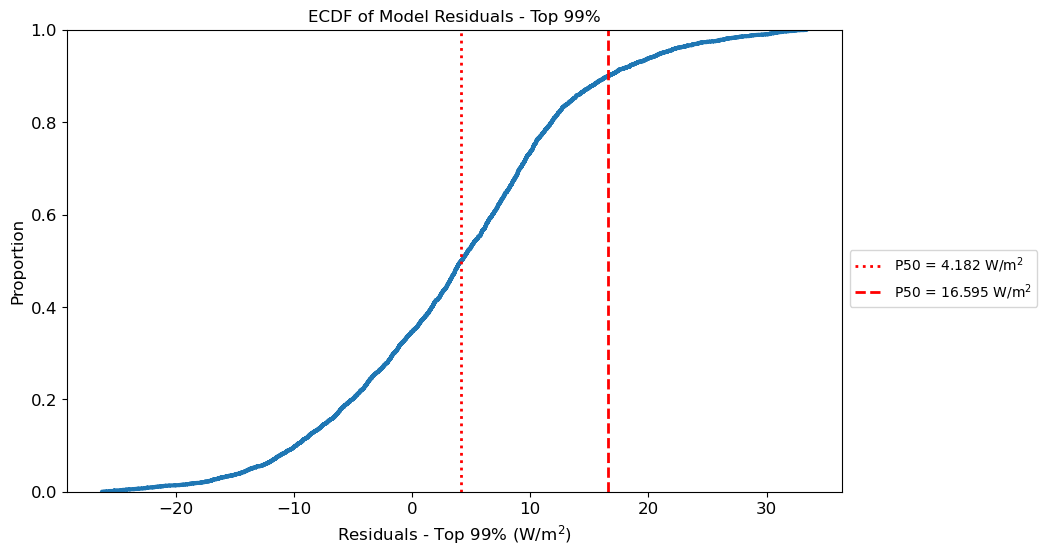

In [17]:
#plot empirical cumulative distribution functions
sns.ecdfplot(data=df, x='resid_trim', linewidth=3)
plt.xlabel('Residuals - Top 99% (W/m$^2$)')
plt.vlines(x=np.percentile(df['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='red',linestyles='dotted')
plt.vlines(x=np.percentile(df['resid_trim'].dropna(), 90), ymin=0, ymax=1, linewidth=2, color='red',linestyles='--')

line_2 = Line2D([0], [0], color='red', linewidth=2, linestyle='dotted',label=('P50 = '+str(round(np.percentile(df['resid_trim'].dropna(), 50),3))+' W/m$^2$'))
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('P50 = '+str(round(np.percentile(df['resid_trim'].dropna(), 90),3))+' W/m$^2$'))

lines = [line_2,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('ECDF of Model Residuals - Top 99%')

Text(0.5, 1.0, 'ECDF of Model at High and Low Clearness Index levels')

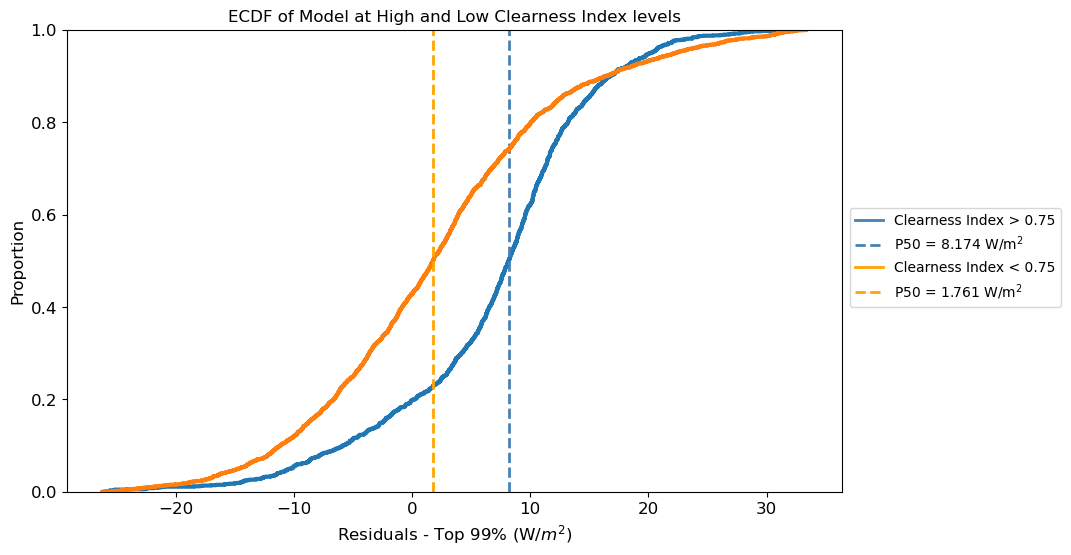

In [18]:
#plotting the ecdf of two groups, determined by the specified metric & boundary
#metric must be a column in the df
metric = 'Clearness Index' #other options could be clearness index, month, etc
#bound dictates how it gets split into lower and higher groups
bound = 0.75

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

sns.ecdfplot(data=df_h, x='resid_trim', linewidth=3)
plt.vlines(x=np.percentile(df_h['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='steelblue',linestyles='dashed')
sns.ecdfplot(data=df_l, x='resid_trim', linewidth=3)
plt.vlines(x=np.percentile(df_l['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='orange',linestyles='dashed')


plt.xlabel('Residuals - Top 99% (W/$m^2$)')

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=(metric+' > '+str(bound)))
line_2 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='--',label=('P50 = '+str(round(np.percentile(df_h['resid_trim'].dropna(), 50),3))+' W/m$^2$'))
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label=(metric+' < '+str(bound)))
line_4 = Line2D([0], [0], color='orange', linewidth=2, linestyle='--',label=('P50 = '+str(round(np.percentile(df_l['resid_trim'].dropna(), 50),3))+' W/m$^2$'))

lines = [line_1,line_2,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('ECDF of Model at High and Low '+metric+' levels')

## Analysis III: Comparison to Baseline Models
#### Comparing the model to other well-known baseline models can provide information about how the model is performing relative to accepted models
In this analysis, the selected baseline model is the Haydavies model

In [19]:
baseline_model = 'haydavies'
df['Baseline Model POA']  = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
                    solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'],dni=df['DNI (W/m2)'],
                    ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=spdf['dni_extra'], model =baseline_model)['poa_global']
#calculate some basic error metrics
df['Baseline Residuals'] = df['Baseline Model POA'] - df['Measured front POA irradiance (W/m2)']
df['Baseline NBE'] = 100 * (df['Baseline Model POA'] - df['Measured front POA irradiance (W/m2)'])/(df['Measured front POA irradiance (W/m2)'])

In [20]:
#using modeled POA to estimate energy to use in an energy yield analysis
df['DC Power - Baseline Model POA'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Baseline Model POA'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Modeled POA'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#find overall % diff for annual energy
print('With initial model POA, predicted annual energy is', round(df['DC Power - Model POA'].sum()/1000,3),
      'kWh and with baseline modeled POA, predicted annual energy is', round(df['DC Power - Baseline Model POA'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using baseline vs modeled POA is ', round(((df['DC Power - Baseline Model POA'].sum()-df['DC Power - Model POA'].sum())/df['DC Power - Model POA'].sum())*100,3),'%')

With initial model POA, predicted annual energy is 6558.366 kWh and with baseline modeled POA, predicted annual energy is 6560.715 kWh
The % difference in energy estimate when using baseline vs modeled POA is  0.036 %


Text(0.5, 1.0, 'Overall NMBE for Model & Baseline Model')

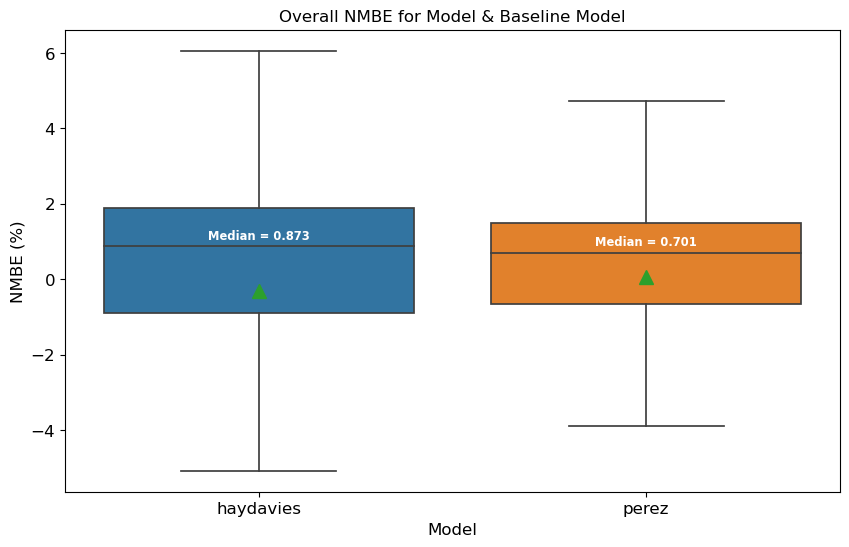

In [21]:
nbe = []
poa_b = 100 * ((df['Baseline Model POA'] - df['Measured front POA irradiance (W/m2)'])/(df['Measured front POA irradiance (W/m2)'])).to_frame()
poa_b.rename(columns = {0 : 'NBE'}, inplace = True)
poa_b['Model'] = baseline_model
nbe.append(poa_b)
test =  100 * ((df['Modeled POA'] - df['Measured front POA irradiance (W/m2)'])/(df['Measured front POA irradiance (W/m2)'])).to_frame()
test.rename(columns = {0 : 'NBE'}, inplace = True)
test['Model'] = model_name
nbe.append(test)
nbe_df = pd.concat(nbe, ignore_index=True)
box_plot = sns.boxplot(x='Model', y='NBE', data=nbe_df, showfliers=False, showmeans=True, meanprops={'markersize':10})
plt.ylabel('NMBE (%)')
medians = nbe_df.groupby(['Model'])['NBE'].median()
vertical_offset = nbe_df['NBE'].median() * 0.25 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,('Median = '+str(round(medians[xtick],3))),horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.title('Overall NMBE for Model & Baseline Model')

Text(0.5, 1.0, 'ECDF of Model & Baseline Model Residuals')

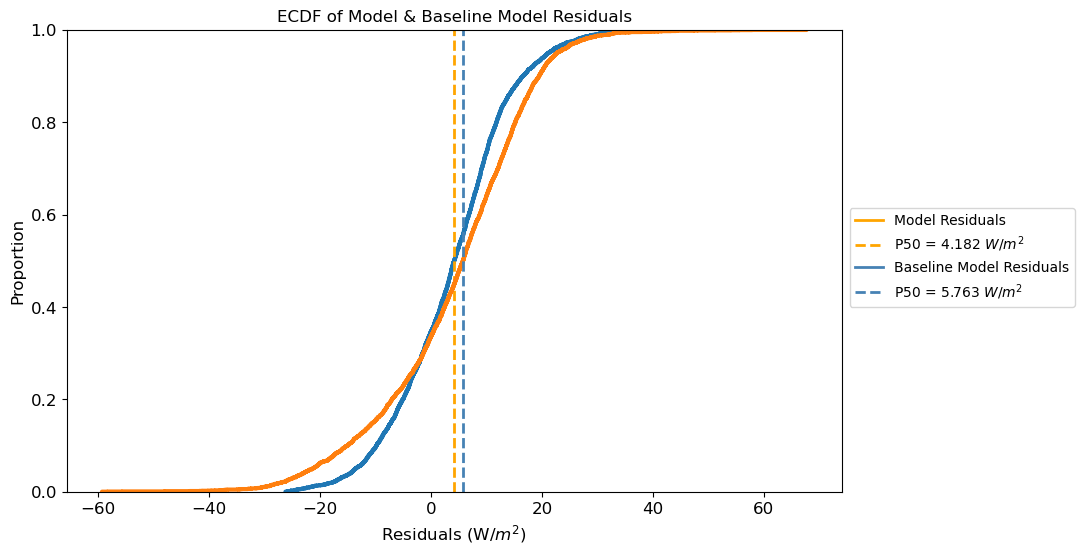

In [22]:
#ecdf of the two models overlayed & p50 given
sns.ecdfplot(data=df, x='Residuals', linewidth=3)
plt.vlines(x=np.percentile(df['Residuals'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='orange',linestyles='dashed')
sns.ecdfplot(data=df, x='Baseline Residuals',linewidth=3)
plt.vlines(x=np.percentile(df['Baseline Residuals'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='steelblue',linestyles='dashed')


plt.xlabel('Residuals (W/$m^2$)')
line_1 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label='Model Residuals')
line_2 = Line2D([0], [0], color='orange', linewidth=2, linestyle='--',label=('P50 ='+' '+str(round(np.percentile(df['Residuals'].dropna(), 50),3))+' $W/m^2$'))
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Baseline Model Residuals')
line_4 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='--',label=('P50 ='+' '+str(round(np.percentile(df['Baseline Residuals'].dropna(), 50),3))+' $W/m^2$'))

lines = [line_1,line_2,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('ECDF of Model & Baseline Model Residuals')

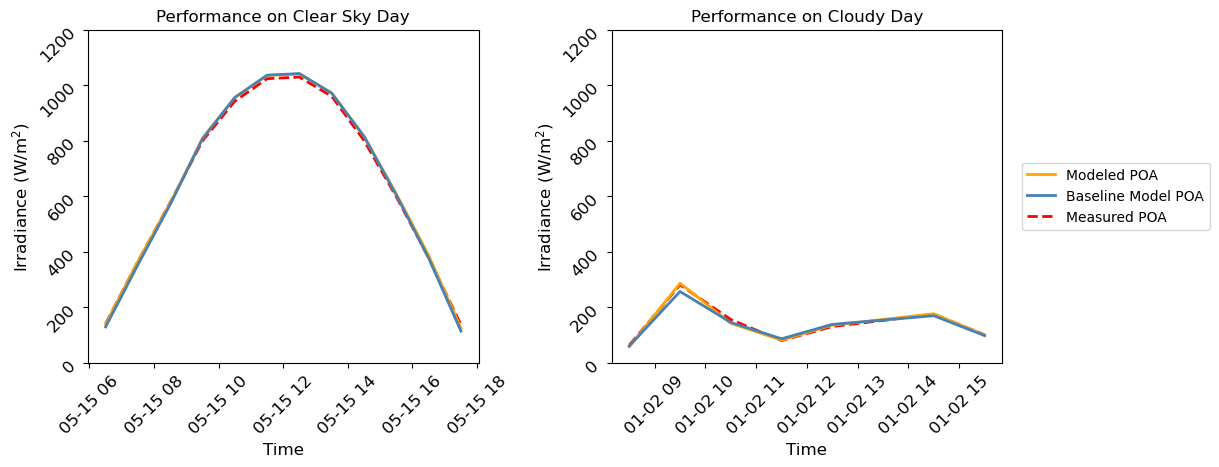

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.tight_layout(w_pad = 5)

#diurnal plot for clearsky day
day = 15
month = 5
ax1.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured front POA irradiance (W/m2)'], linewidth=2, linestyle = 'dashed',color='red', zorder=5.5)
ax1.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Modeled POA'], linewidth=2, color='orange', zorder=5.5)
ax1.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Baseline Model POA'], linewidth=2, color='steelblue', zorder=5.5)
ax1.tick_params(labelrotation = 45)
ax1.set_ylabel('Irradiance (W/m$^2$)')
ax1.set_xlabel('Time')
ax1.set_ylim(0,1200)
plt.grid(False)
ax1.patch.set_visible(False)
ax1.set_title('Performance on Clear Sky Day')

#diurnal plot for cloudy
day = 2
month = 1
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured front POA irradiance (W/m2)'], linewidth=2, linestyle = 'dashed', color='red', zorder=5.5)
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Modeled POA'], linewidth=2, color='orange', zorder=5.5)
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Baseline Model POA'], linewidth=2, color='steelblue', zorder=5.5)
ax2.tick_params(labelrotation = 45)
ax2.set_ylabel('Irradiance (W/m$^2$)')
ax2.set_xlabel('Time')
ax2.set_ylim(0,1200)
plt.grid(False)
ax2.patch.set_visible(False)
ax2.set_title('Performance on Cloudy Day')
line_1 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label='Modeled POA')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Baseline Model POA')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='Measured POA')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.05, 0.4],handles=lines)

Text(0.5, 1.0, 'NMBE (%) of models in different irradiance bins')

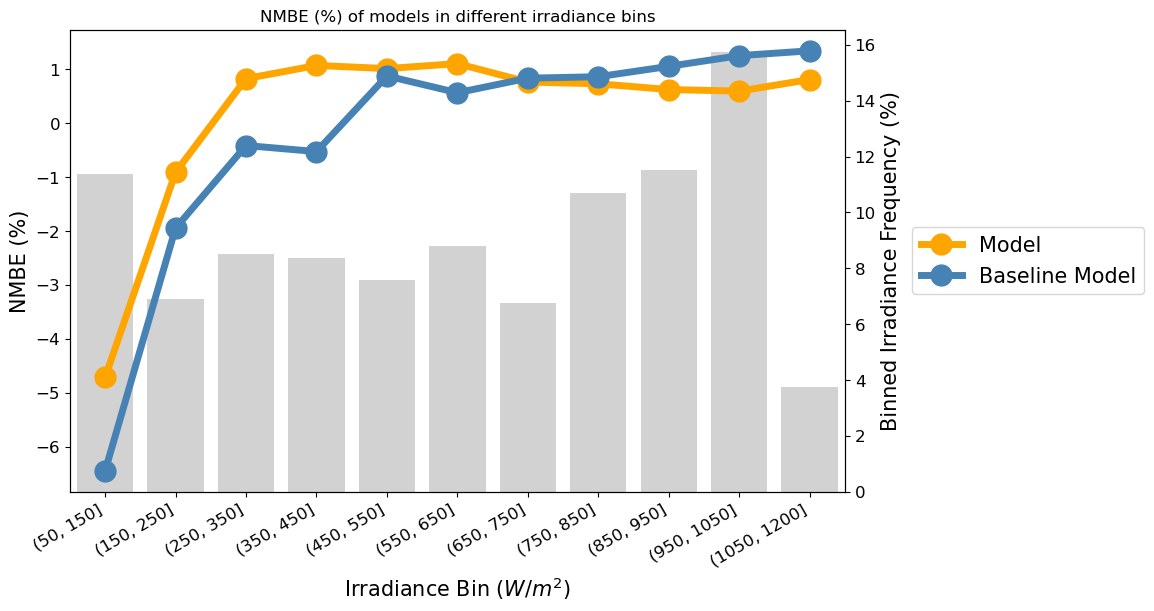

In [24]:
#plotting the model's NMBE at different irradiance levels
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'Irradiance Bins' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df.groupby('Irradiance Bins').mean()['NBE']
ax.plot(x, y, 'orange', marker='o', zorder=6.5, linewidth=5, markersize=15)
y = df.groupby('Irradiance Bins').mean()['Baseline NBE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=5, markersize=15)
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('NMBE (%)', fontsize=15)
ax.set_xlabel('Irradiance Bin ($W/m^2$)', fontsize=15)
#ax.set_title(system+ ' System')
ax.legend(['Model','Baseline Model'],loc='center right',bbox_to_anchor=(1.4, 0.5), fontsize=15)
#ax.set_ylim(-5,10)


ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
plt.title('NMBE (%) of models in different irradiance bins')